In [1]:
# General imports
import sys
import math
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from pathlib import Path
import warnings
# Statistics
import scipy.stats as stats
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf

In [2]:
# Functionality to allow the notebook to run locally or in Colab
# This needs to be adjusted to the local or colab path where the data is stored
COLABPATH = "/content/drive/MyDrive/Colab Notebooks/effective_temperature"
LOCALPATH = "."
# Installation of the required packages on Colab
try:
  import google.colab
  from google.colab import drive
  if not Path('/content/drive').exists():
    drive.mount('/content/drive')
  path = Path(COLABPATH)
except ModuleNotFoundError:
    print("Running in local environment")
    path = Path(LOCALPATH)
    
if (pd.__version__ > '2.1.0'):
    warnings.simplefilter(action='ignore', category=FutureWarning)


Running in local environment


# MODELLING TEMPERATURE SENSATION IN A POULTRY BARN

Meat chickens, also called broilers, in intensive rearing live in closed, controlled environment for about 36-42 days (depending on the target market) before they are brought to the abattoir. During this time, the thermal environment is very important, as chickens have no sweat glands and are prone to suffer from both cold and hot temperatures. Chickens manage their core temperature through heat exchange via their feet and their respiration, but are able to do so only after about 10 days of life. The so-called *thermo-neutral* zone of a chicken, i.e. the thermal range that allows a chicken to maintain a constant core temperature grows over time - the exact ranges are not currently known.

Chickens like humans are affected not only by temperature: humidity also plays a great role. The higher the humidity, the more extreme temperature is perceived, because the higher water contents in the air conducts the heat better. Air flow or air speed also pays an important role: the higher the air speed, the colder it feels. This is called the *windchill effect*. For chickens, our best measure currently is called the *effective temperature* and is a combination of temperature, relative humidity and airspeed.

In order to cater for the different needs of birds during their lifetime, farmers have targets for temperature, relative humidity and some also for airspeed.

Modern barns operate heating and cooling elements automatically via sensor input. The so-called "controller", essentially a computer, uses inputs from sensors and translates them into actions: starting/stopping the heater, ventilators, air flaps and cooling elements. In essence, the controller compares the sensor input to the targets and decides on the action to be taken based on that information. Given that farms are quite large spaces (2,500m$^2$ x 3m height = 7,500m$^3$ is not atypical), controllers try to anticipate changes in the ambient conditions to avoid reaching suboptimal conditions for the animals.

In cold weather, farms try to ventilate less - because then they have to heat the entering cold air which increases the cost of production. In hot weather, farmers use laminar ventilation (called "tunnel ventilation") to employ the windchill effect in cooling down the birds. Farms in hot climate also operate heat exchangers or coolers to mitigate outside conditions.

If controllers were perfect and barns were perfect, the ambient conditions inside would be indentical with the targets. However, that is not true. The sun, for example, has significant impact by heating up the barn; this triggers higher ventilation rates and lower temperatures (or effective temperatures) in the afternoons. At the same time, while heating does change the relative humidity (it dries the air), heating is expensive. If the outside relative humidity is too high, but the temperature is acceptable, controllers will allow for a higher relative humidity. As controller typically do not operate on effective temperature, this means that the thermal sensation will be stronger (colder or hotter).

## Problem statement

The goal of this notebook is to investigate the impact of outside conditions on the effective temperature inside the barn.

For this purpose, data sets are being made available from a particular in southern Europe for one flock or production cycle of 40 days. Available are
- T: Inside temperature as measured by a moving sensor at different positions [ºC]
- RH: Inside relative humidity, measured as above [%]
- AS: Inside air speed, measured as above [m/s]
- CO2: Inside carbon dioxide, measured as above, as an indicator variable for the operation of ventilation system [ppm]

From T, RH and AS we can calculate the inside effective temperature ET [ºC].

We also have daily targets for all the above variables. These targets, however, are "theoretical". Farmers change the target on the spot at the controller,
base on their observation of the birds and experience.

From METEOCAT, we have weather variables for the time of the flock and the location of the farm. This data is available hourly. The variables are:
- t: outside temperature [ºC]
- rh: outside relative humidity [%]
- ws: wind speed [m/s]
- wd: wind direction [º]
- pc: precipitation [mm]
- p: air pressure [hPa]


## The general model

The *effective temperature* $ET$ is a function of the temperature, relative humidity and air speed. Bjerg *et al* have described the effective temperature for broilers as

>$$ET = 0.794 t_{db} + 0.25 t_{wb} - c(d-t_{db}) (v^e-0.2^e)$$

where  
- $t_{wb}$ is the wet bulb temperature (which depends on the relative humidity)
- $t_{db}$ is the dry buld temperature
- $v$ is the air speed
- $c, d, e$ are constants

In order to understand therefore the impact of outside climate on the temperature sensation inside the barn, temperature and humidity need to be considered. Air speed is given by the ventilation and is not a function of outside conditions other than farmers increasing or decreasing air speed in function of outside temperature. 

The temperature inside the barn is a result of the heat production and exchange inside. In general, we should expect that energy conservation means that
>$$ \frac{dQ}{dt} = \dot{Q}_{incoming} + \dot{Q}_{heating} + \dot{Q}_{chickens} - \dot{Q}_{outgoing}$$

where  
- $Q$ is the heat
- $\dot{Q_{incoming}}$ is the heat rate related to air entering the barn
- $\dot{Q_{heating}}$ is the heat rate related to heating and the heat emanating from barn equipment
- $\dot{Q_{chickens}}$ is the heat rate emanating from the chickens themselves (which is related to feed consumption and ergo weight)
- $\dot{Q_{outgoing}}$ is the heat rate related to heat leaving the barn with exhaust air

In this notebook, we are most interested in the relative contribution of $\dot{Q}_{incoming}$ when compared to $\dot{Q}_{heating}$ and $\dot{Q}_{chickens}$. For $\dot{Q}_{incoming}$ we have the outside temperature available for modelling. For $\dot{Q}_{chickens}$, Sheila found a linear relationship between heat production and live weight of the birds. There is no direct measurement related to the operation of the heating or cooling equipment; we do have the target temperature, however, which should be an indication of how much heating and cooling would be required. Target temperatures are adjusted constantly by the farmer, so the curve that we have does not actually represent the setting on the farm controller, but is more of a general target. For ventilation, which is mainly driving the last term on the equation, we have $CO_2$ data as an indicator of the operation of the ventilation system, however. 

Relative humidity, on the other hand, indicates a present state of absolute humidity relative to a maximum humidity given the same temperature. It is inherently temperature-dependent. For the water contents in the barn air, however, we should be able to write a similar conservation equation as above, but with the temperature-independent *absolut humidity*. 

>$$ \frac{dAH}{dt} = \dot{AH}_{incoming} + \dot{AH}_{evaporation} + \dot{AH}_{chickens} - \dot{AH}_{outgoing}$$

where  
- $AH$ is the *absolute humidity*
- $\dot{AH}_{incoming}$ is the absolute humidity entering the barn (for which we have the absolute air humidity as a measure)
- $\dot{AH}_{evaporation}$ is the absolute humidity rate related to evaporation, e.g. from cooling equipment, from drinking water, from the litter and potentially other sources
- $\dot{AH}_{chickens}$ is the humidity emanating from the chickens (mostly through respiration)
- $\dot{AH}_{outgoing}$ is the absolute humidity change related to humidity leaving the barn with exhaust air

We can calculate the absolute humidity inside and outside from the relative humidity, the temperature and the air pressure. We can use $CO_2$ as a measure of air transport through the barn

Given that the effective temperature will depend on the outside temperature and absolute humidity, it makes sense to consider two approaches:
1) Model the inside temperature and absolute humidity independently and then combine the results for calculating the effective temperature
2) Model the effective temperature inside as a function of outside and inside factors

The correlation between the outside and the inside conditions, as measured by the goodness of fit (e.g. through the Pearson correlation coefficient or the $R^2$ measure of a linear regression) should provide us the with the desired answer how strongly the inside thermal sensation depends on outside conditions. Care needs to be taken, however, regarding a possible time shift. It stands to be expected that a change in external conditions will not immediately change internal conditions. In this notebook, we will not consider a timeseries analysis, but it is obvious that both the internal heat production as well as the external heat production are autocorrelated. 

**References**
- Bjaerg et al, Effective Temperature for Poultry and Pigs in Hot Climate, https://www.intechopen.com/books/animal-husbandry-and-nutrition/effective-temperature-for-poultry-and-pigs-in-hot-climate, DOI: 10.5772/intechopen.72821
- Tao and Xin, https://pdfs.semanticscholar.org/ec37/8c494f7e80d4715dfcd1408a47ae7588cfa6.pdf
- Upachaban, Teerapon & KHONGSATIT, Kannika & Radpukdee, Thana. (2016). Mathematical Model and Simulation Study of a Closed-poultry House Environment. International Journal of Technology. 7. 1246. 10.14716/ijtech.v7i7.4744. 
- Sheila T. Nascimento, Alex S.C. Maia, Kifle G. Gebremedhin, Carolina C.N. Nascimento, Metabolic heat production and evaporation of poultry, Poultry Science, Volume 96, Issue 8, 2017, Pages 2691-2698, ISSN 0032-5791, https://doi.org/10.3382/ps/pex094.


## Calculation of absolute humidity

The data in the dataset refers to *relative humidity*. Relative humidity depends on the temperature as the saturation point depends on the temperature. For the regression problem it is therefore necessary to convert the relative humidity (inside and outside to absolute humidity).


>$$AH = \frac{P_A}{R_W · T}$$

where $P_A$ is the actual vapor pressure and $R_W$ the specific gas constant

The actual vapor pressure can be calculated from the relative humidity

>$$P_A = P_S \frac{RH}{100}$$

and the saturation vapor pression can be calculated from the Wagner and Pruss equation (https://pubs.aip.org/aip/jpr/article-abstract/31/2/387/241937/The-IAPWS-Formulation-1995-for-the-Thermodynamic?redirectedFrom=fulltext)


## Preparation of the dataset

In [3]:
# Basic variables and functions for data preparation

# Key and labels of the different features
farm_features = {'ET': 'ET inside','T':'T inside', 'RH': 'RH inside','AH': 'AH inside', 'AS': 'air speed', 'CO2':'CO2 inside', 'weight':'weight'}
weather_features = {'et': 'ET outside','t': 'T outside', 'rh': 'RH outside', 'ah':'AH outside','ws': 'wind speed', 'wd': 'wind direction', 'pc': 'precipitation', 'p': 'air pressure'}
targets_features = {'t_ET': 'ET target','t_T':'T target', 't_RH': 'RH target', 't_AS': 'AS target'}
# Maximum day of production (for filtering). Minimum is assumed to be 0
MAX_DAY_OF_PRODUCTION = 50
# Cutoff for Effective Temperature (for filtering)
ET_MIN = 10
ET_MAX = 50

def create_effective_temperature(T:pd.DataFrame, RH:pd.DataFrame, AS:pd.DataFrame, CO2:pd.DataFrame)->pd.DataFrame:
    """
    Creates an effective temperature DataFrame by merging temperature (T), relative humidity (RH),
    airspeed (AS), and carbon dioxide (CO2) DataFrames. Performs data transformations and cleaning
    before returning the resulting DataFrame.
    
    Args:
        T (pd.DataFrame): DataFrame containing temperature data.
        RH (pd.DataFrame): DataFrame containing relative humidity data.
        AS (pd.DataFrame): DataFrame containing airspeed data.
        CO2 (pd.DataFrame): DataFrame containing carbon dioxide data.
        
    Returns:
        pd.DataFrame: DataFrame containing the merged and transformed data.
    """
    
    T   = T.rename(columns={'value': 'T'}).drop(columns=['observable_name','round_id','round_number'])
    RH  = RH.rename(columns={'value': 'RH'}).drop(columns=['observable_name','round_id','round_number'])
    AS  = AS.rename(columns={'value': 'AS'}).drop(columns=['observable_name','round_id','round_number'])
    CO2 = CO2.rename(columns={'value': 'CO2'}).drop(columns=['observable_name','round_id','round_number'])
    df = pd.merge(pd.merge(pd.merge(T, RH, on=['time', 'day_of_production', 'x', 'y', 'z']), 
                        AS , on=['time', 'day_of_production', 'x', 'y', 'z']), 
                        CO2, on=['time', 'day_of_production', 'x', 'y', 'z'])
    df = transform(df)
    df = clean(df)
    df = df.drop(columns=['x', 'y', 'z'])
    df = reduce_to_hourly(df)
    return df

def post_process(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform post-processing on the given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame to be processed.

    Returns:
        pd.DataFrame: The processed DataFrame.

    """
    df = df[['time','date','hour','day_of_production']+list(farm_features.keys())+list(weather_features.keys())+list(targets_features.keys())]
    df = df.sort_values(by=['day_of_production', 'hour'])
    df = df.set_index('time')
    df = df.asfreq('H')
    
    # Add missing values
    if df.isna().sum().sum() > 0:
        df = df.interpolate()
    return df

def prep_weather_data(weather:pd.DataFrame, start:datetime, end:datetime)->pd.DataFrame:
    """
    Preprocesses weather data. Create a continuous hourly date range from start to end
    and maps measured weather variables onto by that range, interpolating missing values.
    
    Args:
        weather (pd.DataFrame): The weather data to be preprocessed.
        start (datetime): The start date of the date range.
        end (datetime): The end date of the date range.
        
    Returns:
        pd.DataFrame: The preprocessed weather data with interpolated values and merged with the date range.
    """
    
    weather['date'] = weather['time'].dt.date
    weather['hour'] = weather['time'].dt.hour
    # Weather data for some hours is missing, we interpolate the values
    date_range = pd.date_range(start=start, end=end+timedelta(hours=0.5), freq='H')
    df = pd.DataFrame(index=date_range, columns=['date','hour'])
    df['date'] = df.index.date
    df['hour'] = df.index.hour
    df['day_of_production'] = [(row['date']-start.date()).days for _,row in df.iterrows()]
    df = df.merge(weather, left_on=['date','hour'], right_on=['date','hour'],how='left').drop(columns=['day'])
    if df.isna().sum().sum() > 0:
        df = df.interpolate()
    df['et'] = effective_temperature_for_weight_gain(df['t'], df['rh'], 0)
    return df

def merge_weather_data(df:pd.DataFrame, weather:pd.DataFrame, start:datetime)->pd.DataFrame:
    """
    Merge weather data with the observational data. Merging is done on the date and hour columns.
    The resulting DataFrame is sorted by date and hour and the columns are reordered.

    Args:
        df (pd.DataFrame): The DataFrame to merge the weather data with.
        weather (pd.DataFrame): The weather data DataFrame to merge.
        start (datetime): The start datetime for merging.

    Returns:
        pd.DataFrame: The merged DataFrame with weather data.

    """
    df = weather.merge(df, left_on=['date','hour'], right_on=['date','hour'],how='left').drop(columns=['time_y','day_of_production_y']).rename(columns={'day_of_production_x':'day_of_production','time_x':'time'})
    return df

def prep_targets(targets:pd.DataFrame)->pd.DataFrame:
    """
    Preprocesses the target data by calculating the effective temperature (ET) for weight gain.
    
    Args:
        targets (pd.DataFrame): The target data containing columns 'T' (temperature), 'RH' (relative humidity),
                                and 'AS' (air speed).
    
    Returns:
        pd.DataFrame: The preprocessed target data with additional column 'ET' (effective temperature) and
                      renamed columns 'day_of_production', 't_T', 't_RH', 't_AS', and 't_ET'.
    """
    targets['ET'] = effective_temperature_for_weight_gain(targets['T'], targets['RH'], targets['AS'])
    targets.rename(columns={'Day':'day_of_production','T':'t_T','RH':'t_RH','AS':'t_AS','ET':'t_ET'}, inplace=True)
    return targets

def merge_targets(df:pd.DataFrame, targets:pd.DataFrame)->pd.DataFrame:
    """
    Merge target values into the dataset based on the day of production. The target values are interpolated if missing.

    Parameters:
    df (pd.DataFrame): The dataset to merge the target values into.
    targets (pd.DataFrame): The target values to merge into the dataset.

    Returns:
    pd.DataFrame: The dataset with the target values merged.

    """
    # Add target values to the dataset
    days = df['day_of_production'].unique()

    for feature in targets_features.keys():
        df[feature] = -1

    for day in days:
        for feature in targets_features.keys():
            df.loc[df['day_of_production']==day, feature] = np.interp(day, targets['day_of_production'], targets[feature])
    return df

def clean(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the given DataFrame by removing rows with missing values,
    filtering out rows with negative values in 'x', 'y', and 'z' columns,
    filtering out rows with 'day_of_production' values outside the range [0, MAX_DAY_OF_PRODUCTION),
    and optionally filtering out rows with 'ET' values outside the range (ET_MIN, ET_MAX).

    Parameters:
    df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
    pd.DataFrame: The cleaned DataFrame.
    """
    df = df.dropna()
    df = df[(df.x > 0) & (df.y > 0) & (df.z > 0)]
    df = df[(df['day_of_production'] >= 0) & (df['day_of_production'] < MAX_DAY_OF_PRODUCTION)]
    if 'ET' in df.columns:
        df = df[(df['ET'] < ET_MAX) & (df['ET'] > ET_MIN)]
    return df

def transform(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms the input DataFrame by calculating the effective temperature (ET) for weight gain.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing columns 'T' (temperature), 'RH' (relative humidity),
                       and 'AS' (air speed).

    Returns:
    pd.DataFrame: The transformed DataFrame with an additional column 'ET' (effective temperature).

    """
    df['ET'] = effective_temperature_for_weight_gain(df['T'], df['RH'], df['AS'])
    return df

def reduce_to_hourly(df: pd.DataFrame) -> pd.DataFrame:
    """
    Reduce the given DataFrame to hourly data by aggregating the values.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing time series data.

    Returns:
    pd.DataFrame: The reduced DataFrame with hourly data.

    """
    df['hour'] = df['time'].dt.hour
    aggmeth = {'time': 'mean', 'ET': 'median', 'T': 'median', 'RH': 'median', 'AS': 'median', 'CO2': 'median'}
    df = df.groupby(['day_of_production', 'hour']).agg(aggmeth).reset_index()
    df['date'] = df['time'].dt.date
    return df

def add_weight_target(df:pd.DataFrame, weight:pd.DataFrame)->pd.DataFrame:
    """
    Adds the weight target to the dataset. The weight target is interpolated if missing.

    Parameters:
    df (pd.DataFrame): The dataset to add the weight target to.
    weight (pd.DataFrame): The weight target to add to the dataset.

    Returns:
    pd.DataFrame: The dataset with the weight target added.

    """
    days = df['day_of_production'].unique()
    for day in days:
        df.loc[df['day_of_production']==day, 'weight'] = weight[weight['Day']==day]['Weight'].values[0]
    return df

def add_absolute_humidity(df:pd.DataFrame)->pd.DataFrame:
    df['AH'] = [absolute_humidity(row['RH'], row['T']) for _,row in df.iterrows()]
    df['ah'] = [absolute_humidity(row['rh'], row['t']) for _,row in df.iterrows()]
    return df


def effective_temperature_for_weight_gain(t:float, rh:float, v:float)->float:
        """
        Calculates the effective temperature for weight gain based on the given parameters.

        Parameters:
        t (float): Dry bulb temperature in degrees Celsius.
        rh (float): Relative humidity as a percentage.
        v (float): Air speed in meters per second.

        Returns:
        float: The effective temperature for weight gain.

        References:
        - Effective Temperature for Poultry and Pigs in Hot Climate
            https://www.intechopen.com/books/animal-husbandry-and-nutrition/effective-temperature-for-poultry-and-pigs-in-hot-climate
            DOI: 10.5772/intechopen.72821
        - Tao and Xin work: https://pdfs.semanticscholar.org/ec37/8c494f7e80d4715dfcd1408a47ae7588cfa6.pdf
        """
        
        # Constants for weight gain parameters
        c = 0.15
        d = 41
        e = 1

        # Calculate the effective temperature for weight gain
        return 0.794 * t + 0.25 * wetbulb_temperature(t, rh) + 0.7 - c * (d - t) * (v**e-0.2**e)

def wetbulb_temperature(t:float, rh:float)->float:
    """
    Calculates the wet-bulb temperature using the Stull formula.
    
    Parameters:
    t (float): The dry-bulb temperature in degrees Celsius.
    rh (float): The relative humidity as a percentage.
    
    Returns:
    float: The wet-bulb temperature in degrees Celsius.
    
    References:
    - Stull formula; see https://journals.ametsoc.org/doi/10.1175/JAMC-D-11-0143.1
    """
    # Stull formula	Tw = T * arctan[0.151977 * (rh% + 8.313659)^(1/2)] + arctan(T + rh%) - arctan(rh% - 1.676331) + 0.00391838 *(rh%)^(3/2) * arctan(0.023101 * rh%) - 4.686035
    return t*np.arctan(0.151977*(rh + 8.313659)**0.5)+np.arctan(t+rh)-np.arctan(rh-1.676331)+0.00391838*(rh)**1.5*np.arctan(0.023101*rh)-4.686035


def absolute_humidity(RH:float, T:float)->float:
    """
    Calculate the absolute humidity in kg/m^3 given the relative humidity (RH) and temperature (T).
    
    Parameters:
    RH (float): Relative humidity in percentage.
    T (float): Temperature in degrees Celsius.
    
    References:
    https://pubs.aip.org/aip/jpr/article-abstract/31/2/387/241937/The-IAPWS-Formulation-1995-for-the-Thermodynamic?redirectedFrom=fulltext
    
    Returns:
    float: Absolute humidity in g/m^3.
    """
    
    T0 = 273.15 #K
    T = T + T0
    TC = 647.096 #K Critical temperature for water
    t = 1-T/TC
    PC = 22.064e6 # hPa Critical pressure for water
    a1 =-7.85951783
    a2 = 1.84408259
    a3 = -11.7866497
    a4 = 22.6807411
    a5 = -15.9618719
    a6 = 1.80122502
    PS = PC*math.exp(TC/T*(a1*t + a2*t**1.5 + a3*t**3 + a4*t**3.5 + a5*t**4 + a6*t**7.5))
    
    PA = PS*RH/100
    
    RW = 461.5
    AH = PA/(RW*T)*1000 # convert to g/m^3
    
    return AH #g/m^3

In [4]:
# Running the data set preparation or if the prepared data set exists, loading it

basepath = path/"data"

if not basepath.exists():
    print("The data directory does not exist")
    sys.exit(1)
    
FLOCK = "hmkrkyw"
full_dataset = basepath/(FLOCK + '.parquet')
if not full_dataset.exists():
    T =  pd.read_csv(basepath/"temperature.csv", parse_dates=['time'])
    T = clean(T)
    FLOCK = T.loc[0, 'round_id'] 
    start = T['time'].min()
    end = T['time'].max()
    RH = pd.read_csv(basepath/"humidity.csv", parse_dates=['time'])
    AS = pd.read_csv(basepath/"airspeed.csv", parse_dates=['time'])
    CO2 = pd.read_csv(basepath/"co2.csv", parse_dates=['time'])
    weight = pd.read_csv(basepath/"ROSS308_weight_target.csv")
    weather = pd.read_csv(basepath/"weather_station.csv", parse_dates=['time'])

    df = create_effective_temperature(T, RH, AS, CO2)
    df = add_weight_target(df, weight)
    weather = prep_weather_data(weather, start=start, end=end)
    df = merge_weather_data(df, weather, start=start)
    targets = pd.read_csv(basepath/"Targets.csv")
    targets = prep_targets(targets)
    df = merge_targets(df, targets)
    df = add_absolute_humidity(df)
    
    df = post_process(df)
    
    full_dataset = basepath/(FLOCK + '.parquet')
    df.to_parquet(full_dataset)
else:
    df = pd.read_parquet(full_dataset)

In [5]:
df.sample(10)

date  hour  day_of_production         ET  \
time                                                                  
2022-08-14 07:00:00  2022-08-14     7                 10  28.552202   
2022-08-27 01:00:00  2022-08-27     1                 23  23.969634   
2022-09-13 03:00:00  2022-09-13     3                 40  24.795188   
2022-08-07 23:00:00  2022-08-07    23                  3  31.087736   
2022-08-16 04:00:00  2022-08-16     4                 12  28.395836   
2022-08-26 14:00:00  2022-08-26    14                 22  25.889517   
2022-09-02 00:00:00  2022-09-02     0                 29  25.246425   
2022-09-02 21:00:00  2022-09-02    21                 29  24.138051   
2022-09-10 13:00:00  2022-09-10    13                 37  23.393108   
2022-09-10 17:00:00  2022-09-10    17                 37  23.598474   

                             T         RH        AH        AS         CO2  \
time                                                                        
2022-08-14 07:00:00  28.500000  44.000000  0.012310  0.100000  800.000000   
2022-08-27 01:00:00  25.500000  61.000000  0.014453  1.000000  653.500000   
2022-09-13 03:00:00  24.842857  74.285714  0.016944  0.621429  591.214286   
2022-08-07 23:00:00  30.400000  61.000000  0.018922  0.200000  761.000000   
2022-08-16 04:00:00  27.500000  66.000000  0.017477  0.100000  779.000000   
2022-08-26 14:00:00  27.300000  62.000000  0.016237  1.100000  621.000000   
2022-09-02 00:00:00  25.400000  73.000000  0.017199  0.750000  589.500000   
2022-09-02 21:00:00  26.400000  68.000000  0.016942  1.600000  515.500000   
2022-09-10 13:00:00  24.326316  75.000000  0.016634  0.847368  657.315789   
2022-09-10 17:00:00  24.431579  75.000000  0.016734  0.836842  670.578947   

                          weight  ...    rh        ah    ws     wd   pc  \
time                              ...                                     
2022-08-14 07:00:00   315.000000  ...  31.0  0.007612  0.06  310.0  0.0   
2022-08-27 01:00:00  1121.000000  ...  70.0  0.012778  2.19  198.0  0.0   
2022-09-13 03:00:00  2639.714286  ...  76.0  0.015720  0.86  198.0  0.0   
2022-08-07 23:00:00    97.000000  ...  53.0  0.010496  3.85  168.0  0.0   
2022-08-16 04:00:00   406.000000  ...  78.0  0.014939  1.42  144.0  0.0   
2022-08-26 14:00:00  1043.000000  ...  39.0  0.012150  2.00  262.0  0.0   
2022-09-02 00:00:00  1589.000000  ...  92.0  0.015258  0.07  138.0  0.0   
2022-09-02 21:00:00  1634.000000  ...  72.0  0.013998  2.11  149.0  0.0   
2022-09-10 13:00:00  2391.052632  ...  37.0  0.011051  3.59  226.0  0.0   
2022-09-10 17:00:00  2411.263158  ...  68.0  0.014390  6.19  182.0  0.0   

                           p       t_ET        t_T       t_RH  t_AS  
time                                                                 
2022-08-14 07:00:00  1010.31  28.077784  27.571429  60.857143   0.2  
2022-08-27 01:00:00  1013.00  25.278826  24.714286  64.000000   0.2  
2022-09-13 03:00:00  1010.95  22.830265  22.285714  65.000000   0.2  
2022-08-07 23:00:00  1015.06  30.105981  29.714286  57.142857   0.2  
2022-08-16 04:00:00  1007.60  27.808575  27.285714  61.428571   0.2  
2022-08-26 14:00:00  1012.01  25.424840  24.857143  64.000000   0.2  
2022-09-02 00:00:00  1012.03  24.407639  23.857143  64.142857   0.2  
2022-09-02 21:00:00  1009.89  24.407639  23.857143  64.142857   0.2  
2022-09-10 13:00:00  1017.07  23.268662  22.714286  65.000000   0.2  
2022-09-10 17:00:00  1015.22  23.268662  22.714286  65.000000   0.2  

[10 rows x 22 columns]

**The feature set**

| Feature | Explanation |
|---------|-------------|
| time | Timestamp (datetime) of the data point. Original measurements have been reduced to one data point per hour (median) |
| date | Date (datetime.date) of the data point|
| hour | Hour of the day (int) |
| day_of_production| The so-called day of production which is zero at chick placement and then increments by one every calendar day|
| ET | The calculated effective temperature in ºC |
| T | Temperature in ºC |
| RH | Relative humidity inside in %|
| AH | Absolute humidity inside in kg/m$^3$ |
| AS | Air speed in m/s |
| CO2 | The CO$_2$ contents in the air in ppm |
| weight| Target weight of ROSS 308 broilers on the day of production |
| et | Calculated outside effective temperature at ($v$=0)|
| t | Outside temperature in ºC |
| rh | Outside relative humidity in %|
| ah | Absolute humidity outside in kg/m$^3$ |
| ws | Windspeed in m/s|
| wd | Wind direction in º |
| pc | Precipitation in mm|
| p | Outside athmospheric pressure |
| t_T | target temperature in the barn |
| t_RH | target relative humidity in the barn |
| t_AS | target airspeed |
| t_ET | calculated target effective temperature |



## Exploratory data analysis (EDA)

We don't anticipate that the targets for relative humidity, air speed and temperature will be individually relevant, so we retain only the target for effective temperature. We also remove the relative humidity from the data set, as we have the temperature-independent absolute humidity.

In [6]:
# Remove relative humidity columns
if 'RH' in df.columns:
    df.drop(columns=['RH'], inplace=True)
if 'RH' in farm_features.keys():
    del farm_features['RH']
if 'rh' in df.columns:
    df.drop(columns=['rh'], inplace=True)
if 'rh' in weather_features.keys():
    del weather_features['rh']

In [7]:
# Set up the final feature list
features = list(farm_features.keys())+['t_ET']+list(weather_features.keys())

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 965 entries, 2022-08-04 12:00:00 to 2022-09-13 16:00:00
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               965 non-null    object 
 1   hour               965 non-null    int32  
 2   day_of_production  965 non-null    int64  
 3   ET                 965 non-null    float64
 4   T                  965 non-null    float64
 5   AH                 965 non-null    float64
 6   AS                 965 non-null    float64
 7   CO2                965 non-null    float64
 8   weight             965 non-null    float64
 9   et                 965 non-null    float64
 10  t                  965 non-null    float64
 11  ah                 965 non-null    float64
 12  ws                 965 non-null    float64
 13  wd                 965 non-null    float64
 14  pc                 965 non-null    float64
 15  p                  965 non-null    fl

In [9]:
df[features].describe().T

count         mean         std          min          25%          50%  \
ET      965.0    27.326900    3.162719    19.739030    24.932504    27.017693   
T       965.0    27.896192    2.958693    21.900000    25.500000    27.500000   
AH      965.0     0.014796    0.002531     0.007289     0.013199     0.014928   
AS      965.0     0.594041    0.376116     0.000000     0.200000     0.600000   
CO2     965.0   689.238342  200.515988   401.000000   573.000000   643.000000   
weight  965.0  1063.517617  806.264647    42.000000   315.000000   893.000000   
t_ET    965.0    26.258649    2.328319    22.830265    24.266520    25.852070   
et      965.0    26.099423    4.419459    16.189387    22.465424    25.490628   
t       965.0    25.761710    5.047764    15.060000    21.660000    24.970000   
ah      965.0     0.011164    0.002300     0.006246     0.009441     0.011298   
ws      965.0     3.269793    1.739532     0.000000     1.980000     3.000000   
wd      965.0   199.608290   50.672603    13.000000   166.000000   181.000000   
pc      965.0     0.021140    0.238618     0.000000     0.000000     0.000000   
p       965.0  1013.790834    2.897111  1005.440000  1012.090000  1014.190000   

                75%          max  
ET        29.086960    36.071885  
T         29.650000    36.700000  
AH         0.016709     0.021597  
AS         0.900000     1.600000  
CO2      735.250000  2348.000000  
weight  1725.000000  2674.000000  
t_ET      28.077784    31.324269  
et        29.611141    37.525527  
t         29.730000    39.170000  
ah         0.012759     0.018274  
ws         4.340000     8.060000  
wd       237.000000   360.000000  
pc         0.000000     4.500000  
p       1015.770000  1020.200000

In [10]:
# Function to plot a boxplot and a histogram along the same scale
def histogram_boxplot(data: pd.DataFrame, feature:str, figsize:tuple=(12, 7), hue:str=None, kde:bool=False, bins:list=None, stat='count'):
    """Plots a combination of a boxplot and a histogram

    Args:
        data (pd.DataFrame): Dataframe to plot
        feature (str): Column to plot
        figsize (tuple, optional): Size of the figure. Defaults to (12, 7).
        hue (str, optional): Column to use for hue. Defaults to None.
        kde (bool, optional): Plots the KDE in the histogram if True. Defaults to False.
        bins (list, optional): List of bins. Defaults to None.
    """

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows = 2,      # Number of rows of the subplot grid = 2
        sharex = True,  # x-axis will be shared among all subplots
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize)     # Creating the 2 subplots
    sns.boxplot(data = data, x = feature, ax = ax_box2, showmeans = True, color = 'orange')     # Boxplot will be created and a star will indicate the mean value of the column
    if bins:
        sns.histplot(data = data, x = feature, kde = kde, hue=hue, stat=stat, ax = ax_hist2, bins = bins) 
    else:
        sns.histplot(data = data, x = feature, kde = kde, hue=hue, stat=stat,  ax = ax_hist2) # For histogram
    ax_hist2.axvline(data[feature].mean(), color = "red", linestyle = "--")   # Add mean to the histogram
    ax_hist2.axvline(data[feature].median(), color = "black", linestyle = "-")  # Add median to the histogram

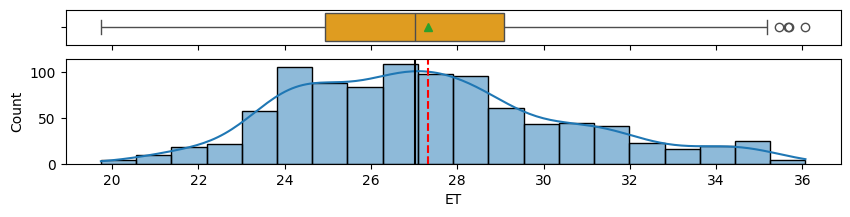

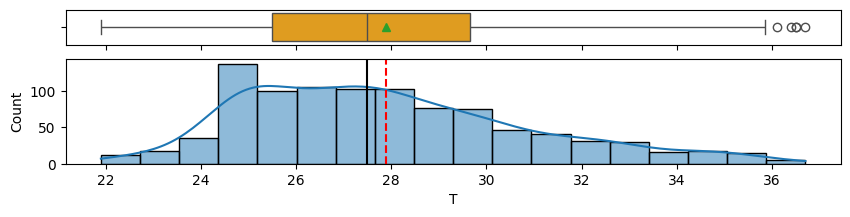

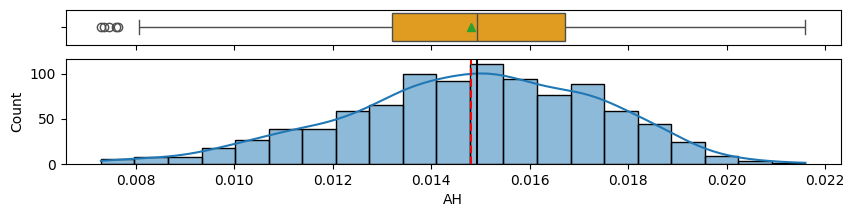

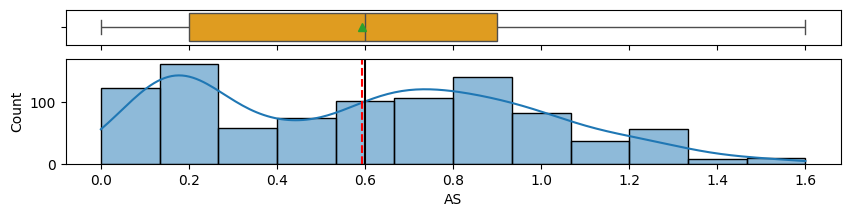

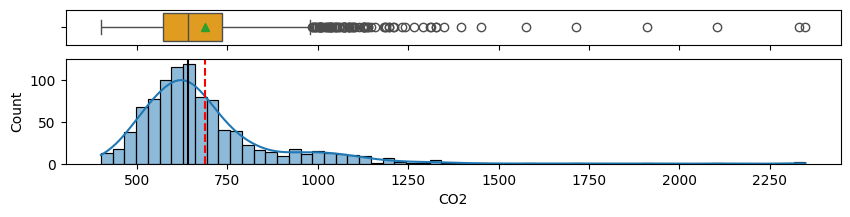

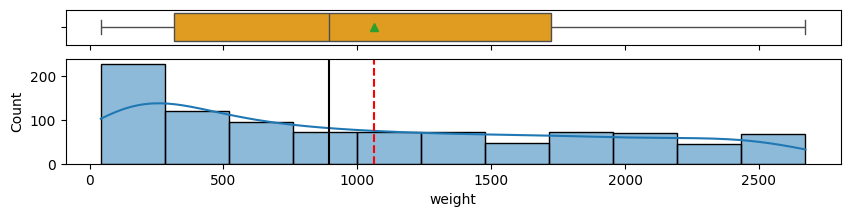

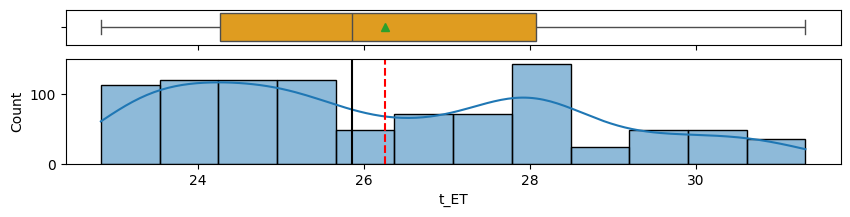

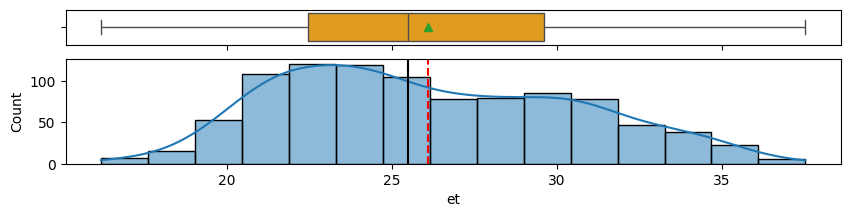

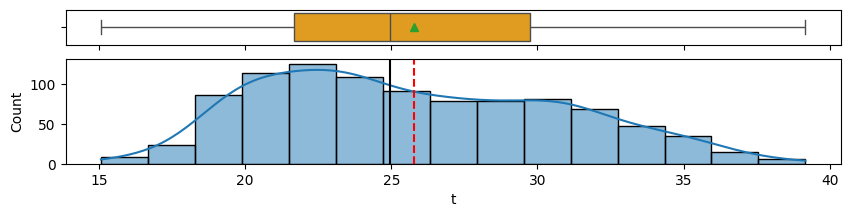

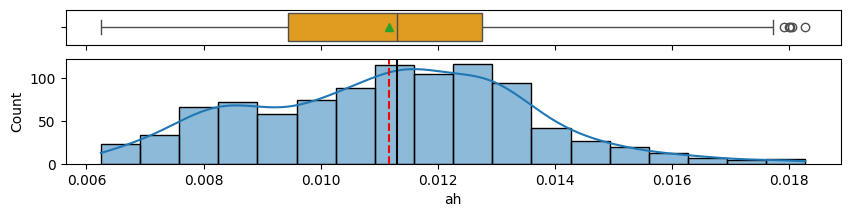

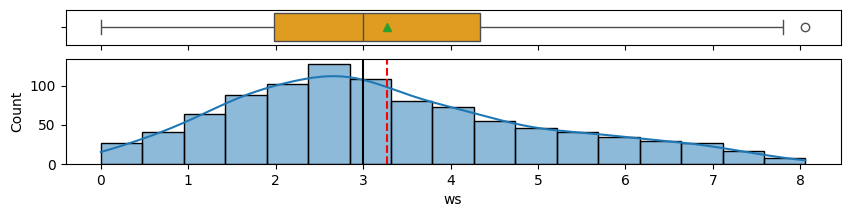

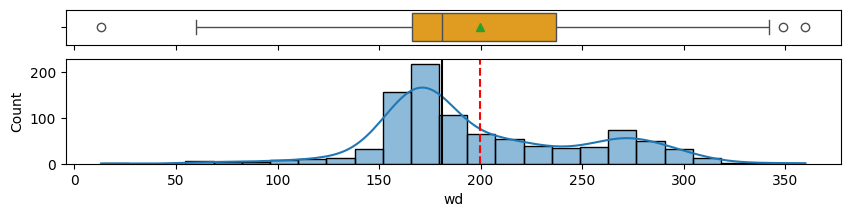

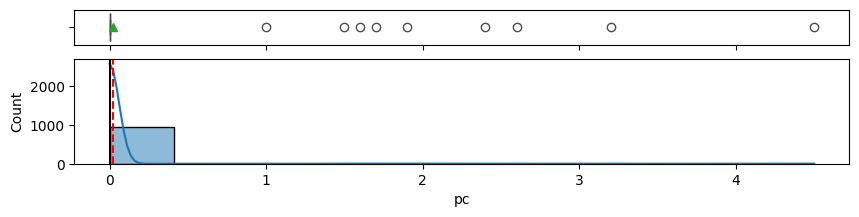

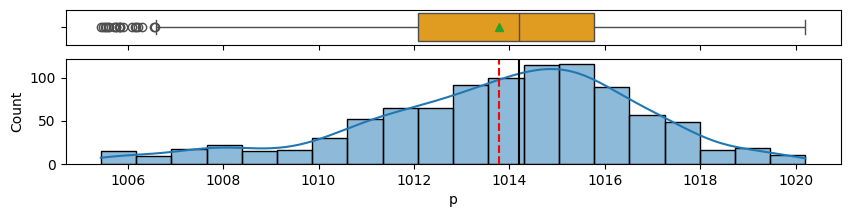

In [11]:
# Plotting numerical features
for col in features:
    histogram_boxplot(df, col, figsize=(10, 2), kde=True)

**Observations**

1) There was very little or no precipitation. This is not going to be a useful feature and should be removed
2) T and ET have few outliers, CO2 quite a few
3) None of the features are normally distributed; AH and ET are nearest to a normal distribution

In [12]:
# Remove precipitation from the features
features.remove('pc')

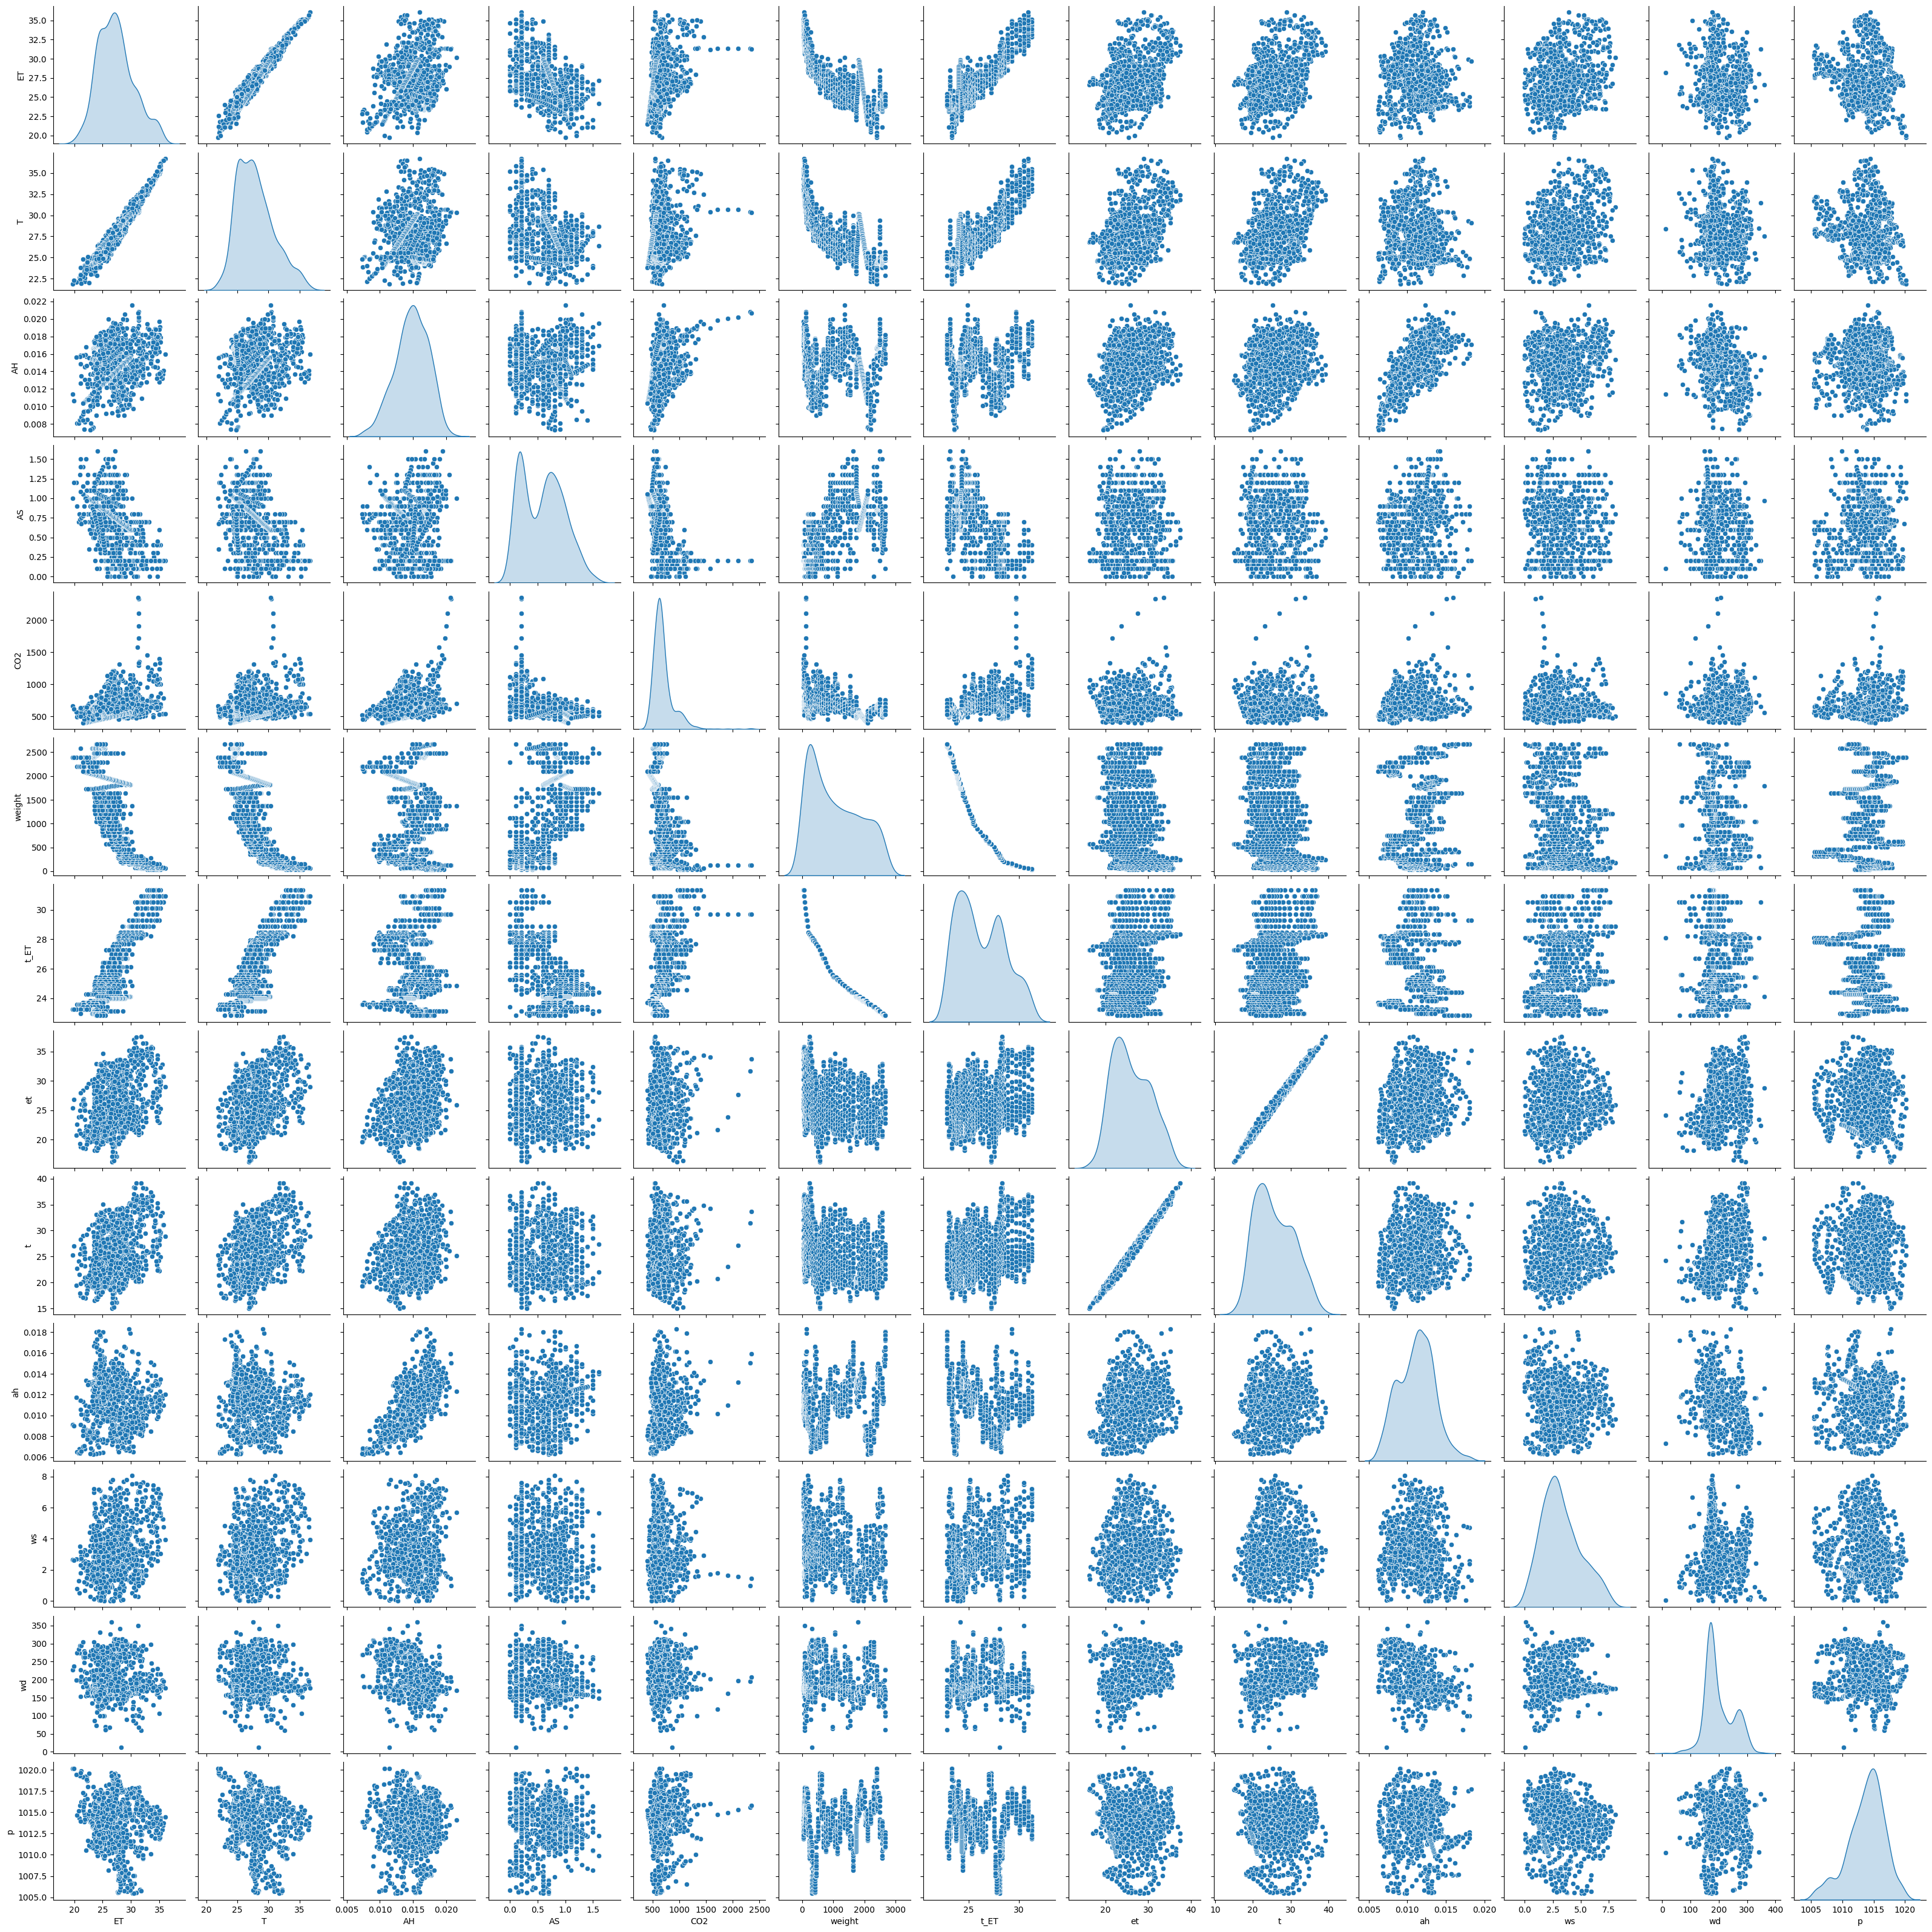

In [13]:
subset = df[features]
sns.pairplot(subset, diag_kind='kde', );

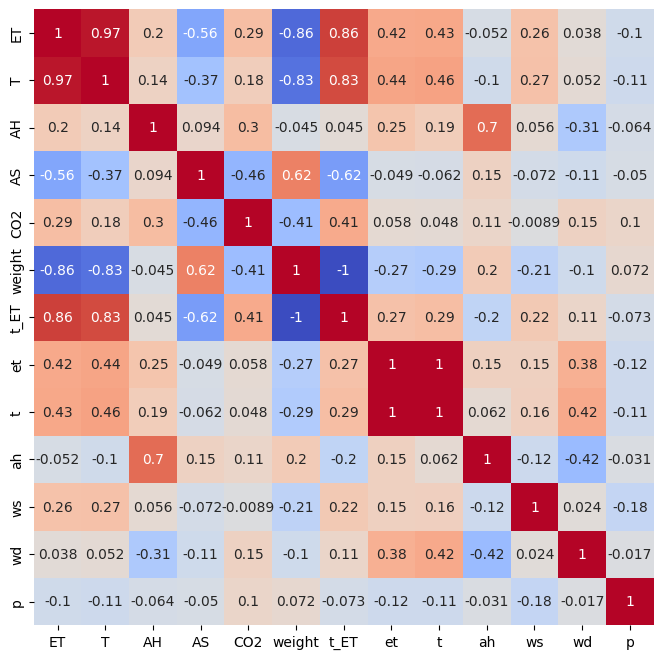

In [14]:
plt.figure(figsize=(8, 8))
# We use spearman instead of pearson because it is more robust to non-linear relationships
sns.heatmap(subset.corr(method='spearman'), annot=True, cmap='coolwarm', center=0, cbar=False);

**Observations**

1) ET is strongly correlated to T and AS (which is just an expression of how the effective temperature is calculated) and less to AH. These three features should be dropped for linear regression
2) ET is medium correlated with t/et.
3) ET is weakly correlated with CO$_2$ and ws (wind speed)
4) ET is strongly (negatively) correlated with weight and (positively) temperature target. The bigger the birds, the less external heat they need to be in the thermoneutral zone, therefore there is less heating - hence the negative correlation with weight.
5) Absolute humidity inside and outside are quite strongly correlated; inside AH is also correlated with CO$_2$, which we use to estimate ventilation rate
6) Given that ET is not strongly correlated with AH, it is very weakly correlated with ah.
7) Wind direction is correlated negatively with t/et and ah; likely some winds are "wetter" and some are warmer than others (but they come from different directions)

Through the introduction of the absolute humidity, we have now decoupled the effective temperature from the air moisture (for this data set). 

### The time component

It is reasonable to assume that outside weather will affect the inside conditions, but perhaps with a certain time delay. It is therefore of interest to see whether the correlation is stronger with a delayed time.

In [15]:
# Simple function to show a time series of ET, T and AH outside/inside and with target
def timeplot(df:pd.DataFrame,xvar:str='date'):
    fig, axs = plt.subplots(1, 3, figsize=(30, 6))

    sns.lineplot(data=df,x=xvar, y='ET', label=farm_features['ET'], ax=axs[0],legend=True)
    sns.lineplot(data=df,x=xvar, y='et', label=weather_features['et'], ax=axs[0],legend=True)
    sns.lineplot(data=df,x=xvar, y='t_ET', label=targets_features['t_ET'], ax=axs[0],legend=True)
    axs[0].set_title('Effective Temperature')
    axs[0].tick_params("x", labelrotation=45)
    #
    sns.lineplot(data=df,x=xvar, y='T', label=farm_features['T'], ax=axs[1],legend=True)
    sns.lineplot(data=df,x=xvar, y='t', label=weather_features['t'], ax=axs[1],legend=True)
    sns.lineplot(data=df,x=xvar, y='t_T', label=targets_features['t_T'], ax=axs[1],legend=True)
    axs[1].set_title('Temperature')
    axs[1].tick_params("x", labelrotation=45)

    sns.lineplot(data=df,x=xvar, y='AH', label=farm_features['AH'], ax=axs[2],legend=True)
    sns.lineplot(data=df,x=xvar, y='ah', label=weather_features['ah'], ax=axs[2],legend=True)
    # sns.lineplot(data=df,x=xvar, y='t_RH', label=targets_features['t_RH'], ax=axs[2],legend=True)
    axs[2].set_title('Absolute Humidity')
    axs[2].tick_params("x", labelrotation=45)
    

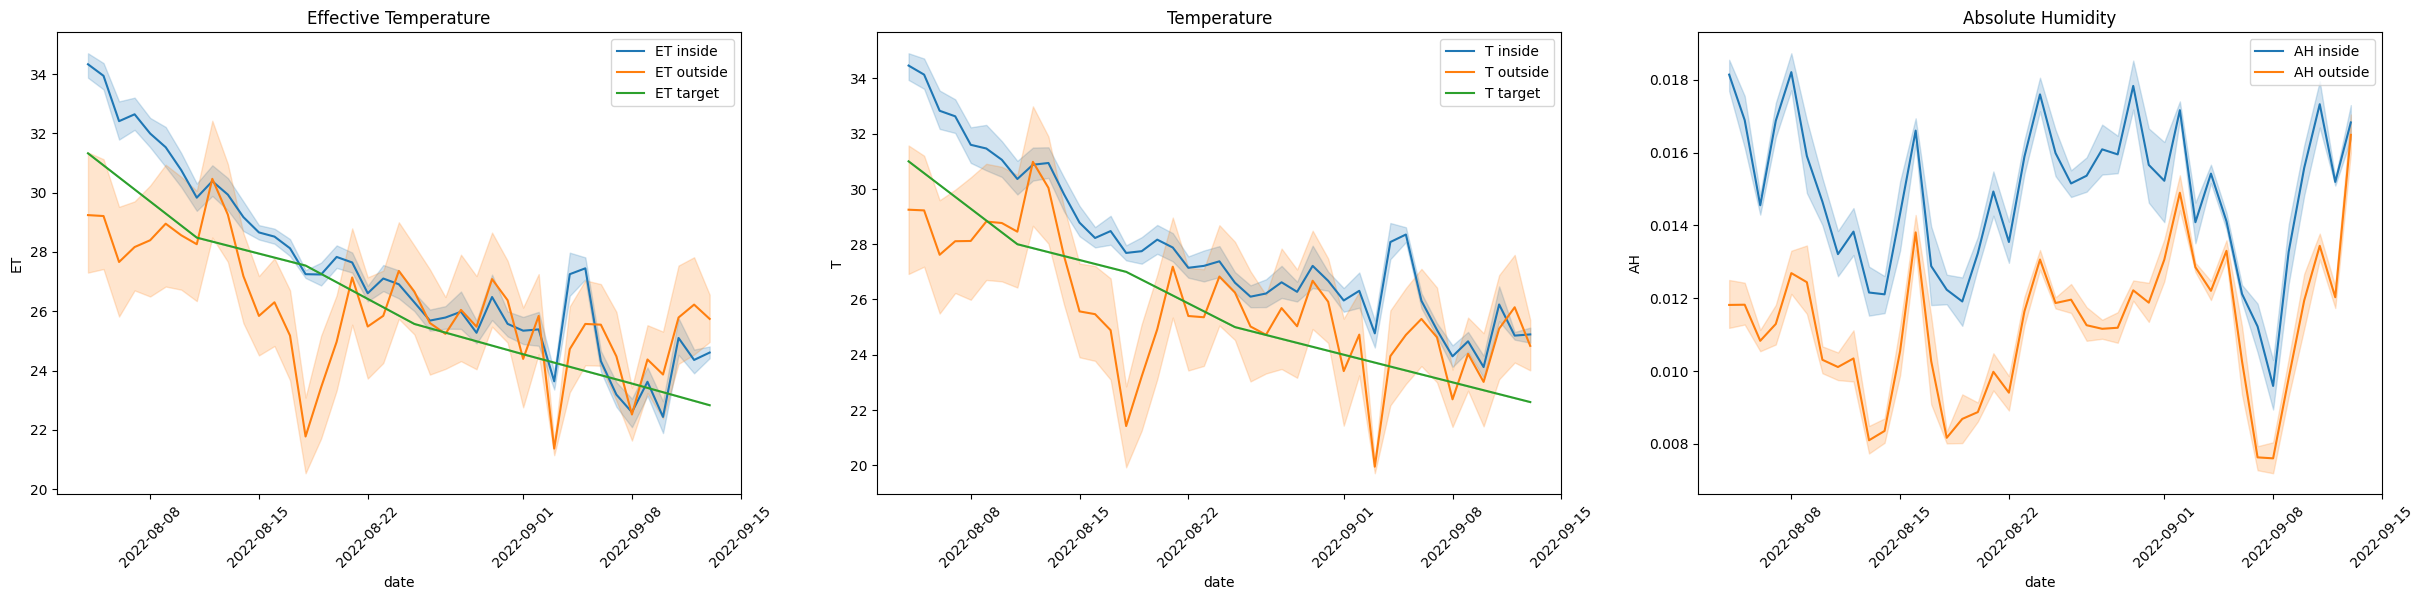

In [16]:
# Show ET, T and AH for each day
timeplot(df)

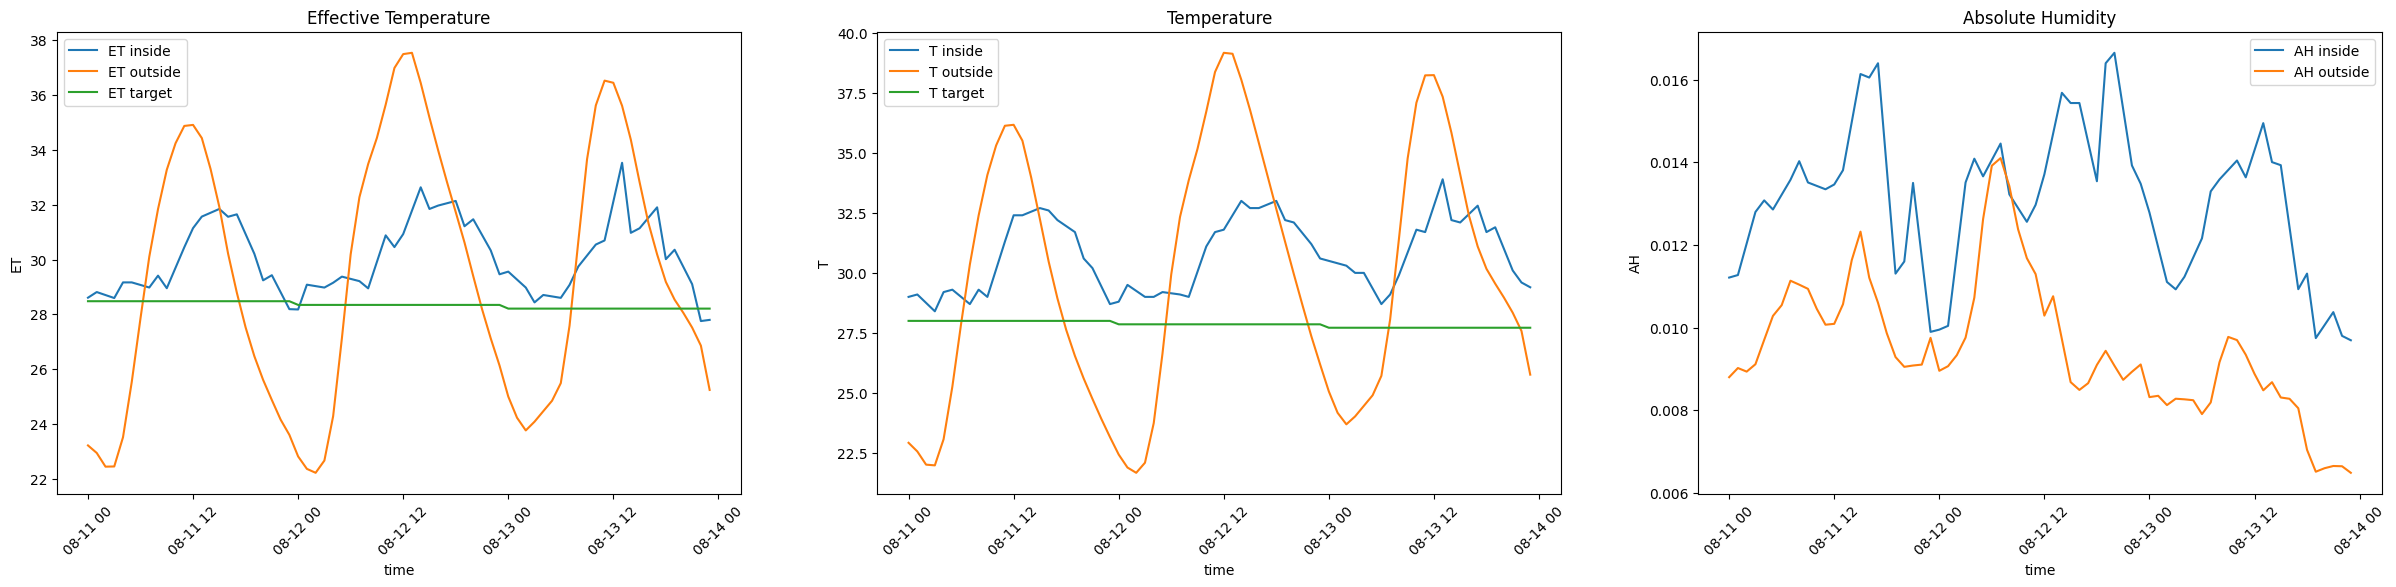

In [17]:
# Now let's zoom in
subset = df[(df['date'] > datetime.strptime('2022-08-10','%Y-%m-%d').date()) & (df['date'] < datetime.strptime('2022-08-14','%Y-%m-%d').date())]
timeplot(subset,xvar='time')

**Observations**

1) Clearly outside conditions have a cyclical nature (daily rhythm) as does the inside (effective) temperature.
2) Inside conditions are stable but when temperature rises too much they deteriorate.
3) The time lag between outside and (a measurable effect) inside is about 3-4h
4) Inside absolute humidity also seems to follow a cyclical pattern, but outside absolute humidity is much more complex
5) There is no observable time lag between inside and outside absolute humidity. This makes sense as the total air in a barn is exchanged 4-8 times an hour.

It therefore makes sense to try a feature where t is shifted by 2-5h


## Feature engineering

As we have seen above, it makes sense to add time-shifted outside temperature and humidity. Let's test what is an appropriate range of shifting.

In [18]:
# Function to add a shifted feature to the DataFrame
def shift_feature(df:pd.DataFrame, feature:str, periods:list[int])->pd.DataFrame:
    """
    Shifts a feature in a DataFrame by the given number of periods.

    Args:
        df 
        (pd.DataFrame): The DataFrame containing the feature to shift.
        feature (str): The feature to shift.
        periods (list[int]): List of periods to shift the feature by.

    Returns:
        pd.DataFrame: The DataFrame with the shifted feature.
    """
    for periods in periods:
        new_feature = f'{feature}p{periods}'
        df[
            new_feature] = df[
            feature].shift(periods)
    return df 

trial = df[['T','AH','t','ah']].copy()
trial = shift_feature(trial, 't', range(1,8))
trial = shift_feature(trial, 'ah', range(1,8))
trial.dropna(inplace=True)
trial = trial[['T','t']+['tp'+str(i) for i in range(1,8)]+['AH','ah']+['ahp'+str(i) for i in range(1,8)]]
trial.head(10)

T      t    tp1    tp2    tp3    tp4    tp5    tp6  \
time                                                                          
2022-08-04 19:00:00  34.75  26.51  27.32  28.50  30.08  31.98  33.93  35.61   
2022-08-04 20:00:00  34.30  25.97  26.51  27.32  28.50  30.08  31.98  33.93   
2022-08-04 21:00:00  34.90  25.48  25.97  26.51  27.32  28.50  30.08  31.98   
2022-08-04 22:00:00  35.50  24.90  25.48  25.97  26.51  27.32  28.50  30.08   
2022-08-04 23:00:00  35.20  24.18  24.90  25.48  25.97  26.51  27.32  28.50   
2022-08-05 00:00:00  34.90  23.40  24.18  24.90  25.48  25.97  26.51  27.32   
2022-08-05 01:00:00  34.90  22.64  23.40  24.18  24.90  25.48  25.97  26.51   
2022-08-05 02:00:00  35.40  22.21  22.64  23.40  24.18  24.90  25.48  25.97   
2022-08-05 03:00:00  35.00  22.41  22.21  22.64  23.40  24.18  24.90  25.48   
2022-08-05 04:00:00  34.60  24.13  22.41  22.21  22.64  23.40  24.18  24.90   

                       tp7        AH        ah      ahp1      ahp2      ahp3  \
time                                                                           
2022-08-04 19:00:00  36.52  0.018176  0.011280  0.011798  0.012310  0.013110   
2022-08-04 20:00:00  35.61  0.017555  0.010703  0.011280  0.011798  0.012310   
2022-08-04 21:00:00  33.93  0.017720  0.010177  0.010703  0.011280  0.011798   
2022-08-04 22:00:00  31.98  0.017875  0.010538  0.010177  0.010703  0.011280   
2022-08-04 23:00:00  30.08  0.017797  0.010778  0.010538  0.010177  0.010703   
2022-08-05 00:00:00  28.50  0.017720  0.009679  0.010778  0.010538  0.010177   
2022-08-05 01:00:00  27.32  0.017720  0.009872  0.009679  0.010778  0.010538   
2022-08-05 02:00:00  26.51  0.018186  0.010418  0.009872  0.009679  0.010778   
2022-08-05 03:00:00  25.97  0.018009  0.010936  0.010418  0.009872  0.009679   
2022-08-05 04:00:00  25.48  0.017832  0.011624  0.010936  0.010418  0.009872   

                         ahp4      ahp5      ahp6      ahp7  
time                                                         
2022-08-04 19:00:00  0.013842  0.013849  0.011848  0.011562  
2022-08-04 20:00:00  0.013110  0.013842  0.013849  0.011848  
2022-08-04 21:00:00  0.012310  0.013110  0.013842  0.013849  
2022-08-04 22:00:00  0.011798  0.012310  0.013110  0.013842  
2022-08-04 23:00:00  0.011280  0.011798  0.012310  0.013110  
2022-08-05 00:00:00  0.010703  0.011280  0.011798  0.012310  
2022-08-05 01:00:00  0.010177  0.010703  0.011280  0.011798  
2022-08-05 02:00:00  0.010538  0.010177  0.010703  0.011280  
2022-08-05 03:00:00  0.010778  0.010538  0.010177  0.010703  
2022-08-05 04:00:00  0.009679  0.010778  0.010538  0.010177

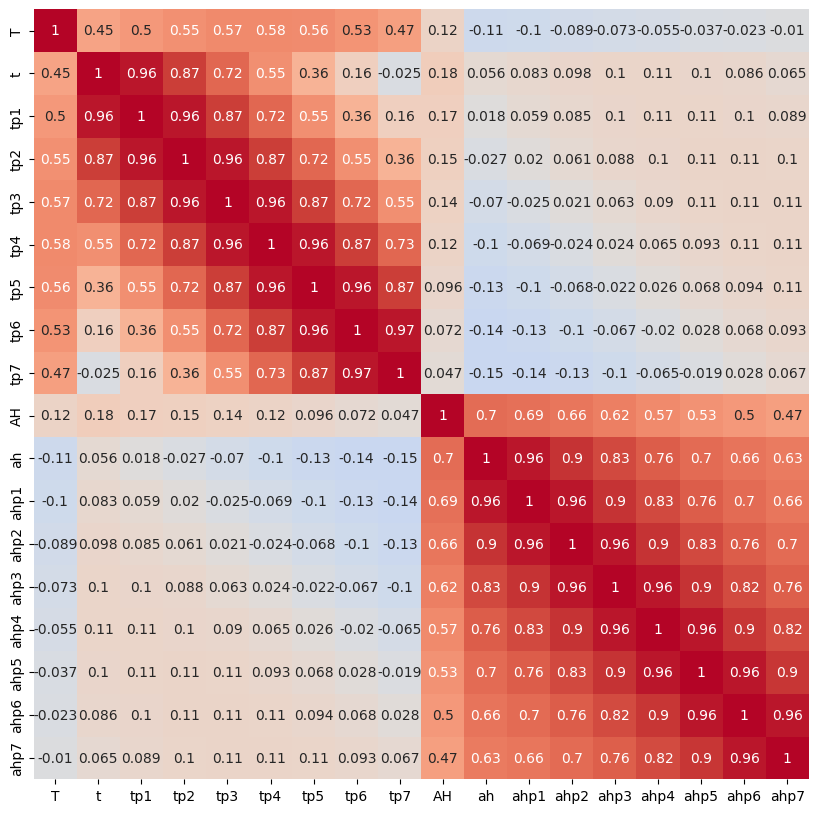

In [19]:
plt.figure(figsize=(10, 10))
sns.heatmap(trial.corr(method='spearman'), annot=True, cmap='coolwarm', center=0, cbar=False);

**Observations**

1) Currently, we are not analysing the data as timeseries, but the autocorrelation in ah and t is clearly visible. This will be subject of another study.
2) With respect to T, there is a peak in correlation at 4h
3) With respect to AH, as seen above, the correlation is strongest with ah (i.e. no time shift)

It therefore makes sense to add tp3, tp4 and tp5 to the data set.

In [20]:
# Add the new features to the data set under investigation
df = shift_feature(df, 't', range(3,6))
df.dropna(inplace=True)
df.sample(10)

date  hour  day_of_production         ET     T  \
time                                                                        
2022-08-24 12:00:00  2022-08-24    12                 20  27.738141  28.4   
2022-09-13 14:00:00  2022-09-13    14                 40  25.057623  24.9   
2022-08-27 04:00:00  2022-08-27     4                 23  24.448768  23.8   
2022-08-19 01:00:00  2022-08-19     1                 15  26.842105  27.1   
2022-09-09 07:00:00  2022-09-09     7                 36  21.819025  22.2   
2022-08-11 13:00:00  2022-08-11    13                  7  31.562108  32.4   
2022-08-15 14:00:00  2022-08-15    14                 11  30.124695  31.0   
2022-09-13 08:00:00  2022-09-13     8                 40  24.439980  24.7   
2022-08-21 17:00:00  2022-08-21    17                 17  28.511024  29.5   
2022-08-10 08:00:00  2022-08-10     8                  6  30.249840  30.3   

                           AH   AS    CO2  weight         et  ...     wd   pc  \
time                                                          ...               
2022-08-24 12:00:00  0.017529  1.2  587.0   893.0  33.576848  ...  178.0  0.0   
2022-09-13 14:00:00  0.016035  0.6  646.0  2674.0  24.438158  ...  100.0  2.4   
2022-08-27 04:00:00  0.014853  0.1  829.0  1121.0  23.171150  ...  212.0  0.0   
2022-08-19 01:00:00  0.012685  0.3  879.0   565.0  16.482280  ...  252.0  0.0   
2022-09-09 07:00:00  0.014537  0.7  578.0  2290.0  24.913488  ...  263.0  0.0   
2022-08-11 13:00:00  0.013810  0.6  534.0   204.0  34.422090  ...  187.0  0.0   
2022-08-15 14:00:00  0.011533  0.6  623.0   359.0  30.434602  ...  276.0  0.0   
2022-09-13 08:00:00  0.018121  0.8  643.0  2674.0  28.086505  ...  229.0  0.0   
2022-08-21 17:00:00  0.015658  0.7  707.0   688.0  29.143839  ...  313.0  0.0   
2022-08-10 08:00:00  0.014501  0.2  816.0   173.0  33.022398  ...  185.0  0.0   

                           p       t_ET        t_T       t_RH  t_AS    tp3  \
time                                                                         
2022-08-24 12:00:00  1013.01  25.852070  25.285714  63.714286   0.2  32.02   
2022-09-13 14:00:00  1011.95  22.830265  22.285714  65.000000   0.2  26.04   
2022-08-27 04:00:00  1012.94  25.278826  24.714286  64.000000   0.2  20.93   
2022-08-19 01:00:00  1017.60  27.258150  26.714286  62.285714   0.2  18.15   
2022-09-09 07:00:00  1016.44  23.414794  22.857143  65.000000   0.2  22.64   
2022-08-11 13:00:00  1013.33  28.481598  28.000000  60.000000   0.2  35.31   
2022-08-15 14:00:00  1006.69  27.943180  27.428571  61.142857   0.2  31.67   
2022-09-13 08:00:00  1011.31  22.830265  22.285714  65.000000   0.2  23.65   
2022-08-21 17:00:00  1010.88  26.695718  26.142857  62.857143   0.2  33.75   
2022-08-10 08:00:00  1017.37  28.887694  28.428571  59.285714   0.2  25.99   

                       tp4    tp5  
time                               
2022-08-24 12:00:00  30.18  27.96  
2022-09-13 14:00:00  26.92  27.34  
2022-08-27 04:00:00  19.87  19.91  
2022-08-19 01:00:00  19.04  19.87  
2022-09-09 07:00:00  23.03  22.50  
2022-08-11 13:00:00  34.08  32.39  
2022-08-15 14:00:00  30.14  28.36  
2022-09-13 08:00:00  22.96  23.10  
2022-08-21 17:00:00  34.37  34.18  
2022-08-10 08:00:00  22.96  21.35  

[10 rows x 23 columns]

In [21]:
# Remove the outside et and add tp3, tp4 and tp5 to the feature set
features.remove('et')
features +=['tp3','tp4','tp5']

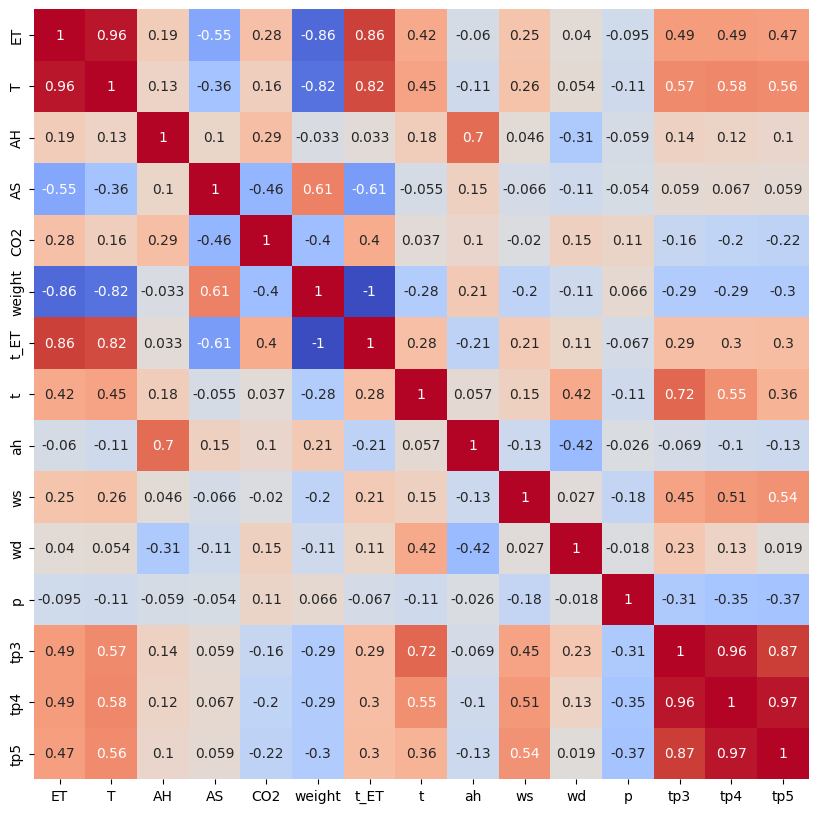

In [22]:
# And plot
plt.figure(figsize=(10, 10))
sns.heatmap(df[features].corr(method='spearman'), annot=True, cmap='coolwarm', center=0, cbar=False);

# Estimating the impact of outside conditions by linear regression

In order to estimate the impact of outside conditions on inside conditions, we will model ET as a linear combination of the features and analyse the results

In [23]:
# We need to drop the temperature, absolute humidity and the outside effective temperature
features.remove('T')
features.remove('AH')
target_feature = 'ET'
features.remove(target_feature)
features

['AS',
 'CO2',
 'weight',
 't_ET',
 't',
 'ah',
 'ws',
 'wd',
 'p',
 'tp3',
 'tp4',
 'tp5']

For better relative comparability, we will now scale the features. We will use a MinMaxScaler given that the features are not really normally distributed.

In [24]:
sc = MinMaxScaler()
X = sc.fit_transform(df[features])
y = df[target_feature].values

df_scaled = pd.DataFrame(X, columns=features)
df_scaled[target_feature] = y

# define the formula for linear regression
formula = target_feature + ' ~ ' + '+'.join(features)

In [25]:
# Using statsmodel with the full feature set
lm = smf.ols(formula=formula, data=df_scaled).fit()
print(lm.summary())  #Inferential statistics

                            OLS Regression Results                            
Dep. Variable:                     ET   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     600.3
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        13:44:19   Log-Likelihood:                -1425.7
No. Observations:                 960   AIC:                             2877.
Df Residuals:                     947   BIC:                             2941.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.0686      0.438     45.783      0.0

In [26]:
# Checking the covariance matrix whose off-diagonal elements should be close to zero
cov_matrix = lm.cov_params() #Covariance matrix
min = -0.2# cov_matrix.min().min()
max = 0.2 # cov_matrix.max().max()

def colour_dataframe(styler,min,max):
    styler.background_gradient(axis=None, vmin=min, vmax=max, cmap='coolwarm')
    return styler

cov_matrix.style.pipe(colour_dataframe,min,max)

In order to better understand the results, it is important to look at the confidence intervals and p-values but also at *multi-collinearity*. Multicollinearity is when two or more features are **linearly** related. Multi-collinearity does not affect the quality of prediction, but it affects significantly the coefficients. For our problem statement multi-collinearity is therefore a relevant issue.

Multi-collinearity can be observed by looking at the covariance matrix and in particular the off-diagonal elements, but is typically measured using the variance inflation factor (VIF).

>$$VIF_i = \frac{1}{1-R_i^2}$$

where $R^2_i$ is the result of a linear regression of feature $i$ with all other features.

Different sources mention different thresholds, but in general VIF > 5 or VIF > 10 are considered to be problematic.

In [27]:
# Function to make a nice table with coefficient, std err, confidence interval and p-value and let's colour everything that is significant
def make_table(lm1: smf.ols, features: list, df: pd.DataFrame, figsize=(10,5)):
    color_accepted = 'lightblue'
    color_rejected = 'orange'

    variables = ['Intercept']+features
    display = pd.DataFrame(index=variables, columns=['Coefficient','Std. Error','CI','p-value','VIF'])
    colors = pd.DataFrame(index=variables, columns=['Coefficient','Std. Error','CI','p-value'])

    def color_significance(var: str, value1: float, value2)->str:
        match var:
            case 'p-value':
                return color_accepted if value1 < 0.05 else color_rejected
            case 'CI':
                return color_rejected if value1 < 0 < value2 else color_accepted
            case 'VIF':
                return color_rejected if value1 > 10 else color_accepted
            case _:
                raise ValueError(f"Unknown value {var}")

    def multicollinearity(var: str, variables:list, df: pd.DataFrame)->float:
        mlr_model = linear_model.LinearRegression()
        test_variables = variables.copy()
        if var not in variables:
            return 0.0
        test_variables.remove(var)
        mlr_model.fit(df[test_variables], df[var])
        rsq = mlr_model.score(df[test_variables], df[var])
        return 1/(1-rsq)

    for var in ['Intercept']+features:
        display.loc[var,'Coefficient'] = f"{lm1.params[var]:.3f}"
        display.loc[var,'Std. Error'] = f"{lm1.bse[var]:.3f}"
        display.loc[var,'CI'] = f"{lm1.conf_int().loc[var,0]:.3f} to {lm1.conf_int().loc[var,1]:.3f}"
        display.loc[var,'p-value'] = f"{lm1.pvalues[var]:.3f}"
        display.loc[var,'VIF'] = f"{multicollinearity(var, features, df):.3f}"
        colors.loc[var,'Coefficient'] = 'white'
        colors.loc[var,'Std. Error'] = 'white'
        colors.loc[var,'CI'] = color_significance('CI', lm1.conf_int().loc[var,0], lm1.conf_int().loc[var,1])
        colors.loc[var,'p-value'] = color_significance('p-value', lm1.pvalues[var], 0)
        colors.loc[var,'VIF'] = color_significance('VIF', multicollinearity(var, features, df), 0)

    _, ax = plt.subplots(figsize=figsize) 
    ax.set_axis_off() 
    table = ax.table( 
        cellText = display.values,  
        rowLabels = display.index,  
        colLabels = display.columns, 
        cellColours=colors.values,  
        colColours =["darkgreen"] * len(display.columns), 
        cellLoc ='center',  
        loc ='upper left',
        colWidths=[0.1,0.1,0.2,0.25,0.1,0.1])         
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    ax.set_title('Results from linear regression', 
                fontweight ="bold") 
    
    plt.tight_layout()
    plt.show()


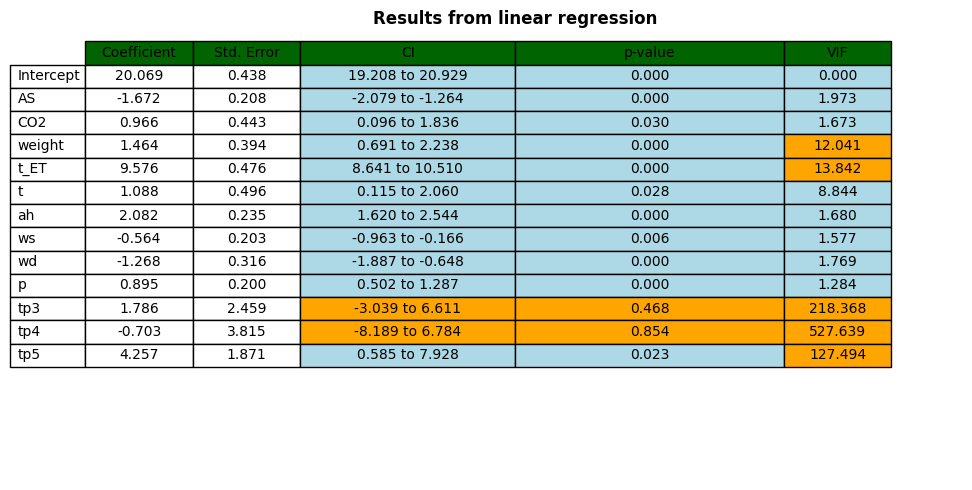

In [28]:
# Formatting a table with the coefficients, standard errors, confidence intervals, p-values and VIFs
make_table(lm, features, df_scaled)

The results clearly indicate that weight and t_T, as well as [t], tp3, tp4 and tp5 are linearly related. This is not surprising.

Animals grow monotonously with the day of production; the temperature target diminishes monotonously with the day of production. While both are not exactly linear dependencies, a line is still a reasonable approximation - which means that one can be expressed as a function of the other (or both as a function of the day of production). 

That there is multi-collinearity between t, tp3, tp4, tp5 is simply an expression of the autocorrelation of the outside temperature. Analysing autocorrelation is beyond the brief of this notebook, but is clearly necessary.

In order to progress with the problem statement, we will drop weight, tp3 and tp5.

In [29]:
# Define an adjusted feature set and the corresponding formula for linear regression
adj_features = ['t_ET','AS','CO2','tp4','ah']
formula = target_feature + ' ~ ' + '+'.join(adj_features)

In [30]:
# OLS with the adjusted features
lm = smf.ols(formula=formula, data = df_scaled).fit()
print(lm.summary())  #Inferential statistics

                            OLS Regression Results                            
Dep. Variable:                     ET   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1309.
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        13:44:20   Log-Likelihood:                -1469.3
No. Observations:                 960   AIC:                             2951.
Df Residuals:                     954   BIC:                             2980.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.1470      0.176    120.170      0.0

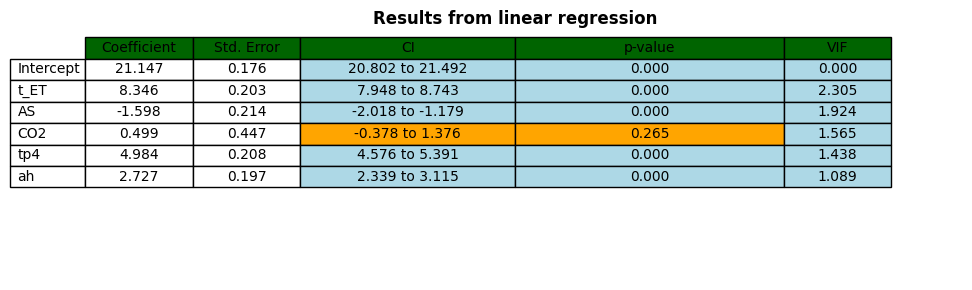

In [31]:
# Formatting a table with the coefficients, standard errors, confidence intervals, p-values and VIFs
make_table(lm, adj_features, df_scaled, figsize=(10,3))

After reducing the feature set and running another linear regression, we can see now that the correlation with CO$_2$ does not yield a reliable correlation coefficient. We remove CO$_2$ from the feature set.

In [32]:
adj_features.remove('CO2')
formula = target_feature + ' ~ ' + '+'.join(adj_features)

In [33]:
# let us get a more detailed model through statsmodel.
lm = smf.ols(formula=formula, data=df_scaled).fit()
print(lm.summary())  #Inferential statistics

                            OLS Regression Results                            
Dep. Variable:                     ET   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1635.
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        13:44:20   Log-Likelihood:                -1469.9
No. Observations:                 960   AIC:                             2950.
Df Residuals:                     955   BIC:                             2974.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.2251      0.161    131.449      0.0

Removal of CO$_2$ has not diminished $R^2$. We now have a model without multi-collinearity and with relevant coefficients

In [34]:
make_table(lm, adj_features, df_scaled, height=310)

TypeError: make_table() got an unexpected keyword argument 'height'

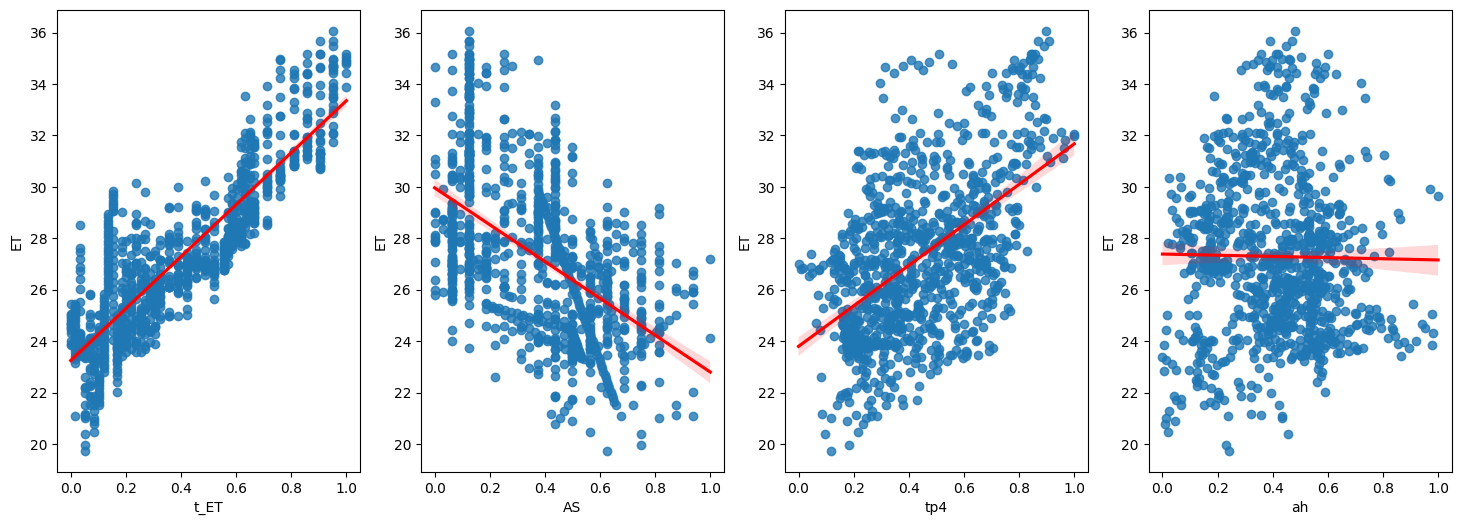

In [ ]:
# Plotting the regression plots
cols, rows = 4, 1
fig, axes = plt.subplots(ncols = cols, nrows = rows, figsize=(18,6))

for idx, var in enumerate(adj_features):
    col = idx % cols
    row = idx // cols
    if rows == 1:
        ax = axes[col]
    else:
        ax = axes[row][col] 
    sns.regplot(data=df_scaled, x=var, y='ET', ax=ax, line_kws=dict(color="r"))


Visualisation shows some heteroscedasticity for extreme values (especially of the outside absolute humidity) 

In order to judge the quality of the linear regression, it is important to check whether the residuals are normally distributed. If the residuals are not normally distributed, there is still information contained in them and the fit can be improved.

In [ ]:
# Obtain predictions and residuals
y_pred = lm.predict(df_scaled[adj_features])
residuals = df_scaled['ET'] - y_pred

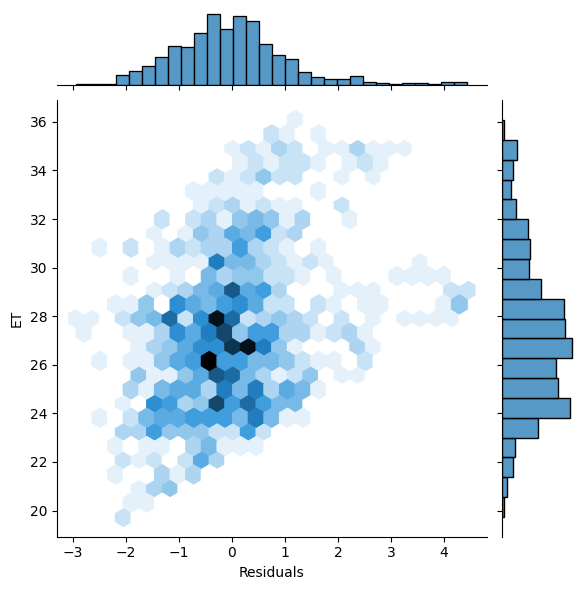

In [ ]:
# Plot residuals against ET
plot = sns.jointplot(y=df_scaled['ET'],x=residuals, kind='hex')
plot.set_axis_labels('Residuals','ET');

In [ ]:
# Check for normality using the Shapiro-Wilk test
# This test delivers a correct p-values for small sample sizes < 5000

stat, p = stats.shapiro(residuals)

if residuals.shape[0] > 5000:
    print(f'The sample size {residuals.shape[0]} is too large for accurate p-values from the Shapiro-Wilk test')
    print(f'The test statistic is {stat:.3f}')
else:
    if p<0.05:
        print(f'According to the Shapiro-Wilk test, the residuals are not normally distributed (p-value {p:.3e})')
    else:
        print(f'According to the Shapiro-Wilk test, the residuals are normally distributed (p-value {p:.3e})')



According to the Shapiro-Wilk test, the residuals are not normally distributed (p-value 1.823e-16)


Both plot and Shapiro-Wilk test show that the residuals are *not* normally distributed. This means that we still have information in the residuals, i.e. the model is only partial. With an $R^2$ of 0.874 this is not surprising. We also have a number of confounding variables, such as the ventilation rate and the heating rate which have major impact on the effective temperature in the barn. 

Let us know inspect the resulting fit as a timeseries.

In [ ]:
# Obtail the linear model for the *non-scaled* data
lm = smf.ols(formula= 'ET ~ t_ET+AS+ah+tp4', data = df).fit()
# Predict the values
df['ET_pred'] = lm.predict(df[adj_features])
df['Residuals'] = df['ET']-df['ET_pred']

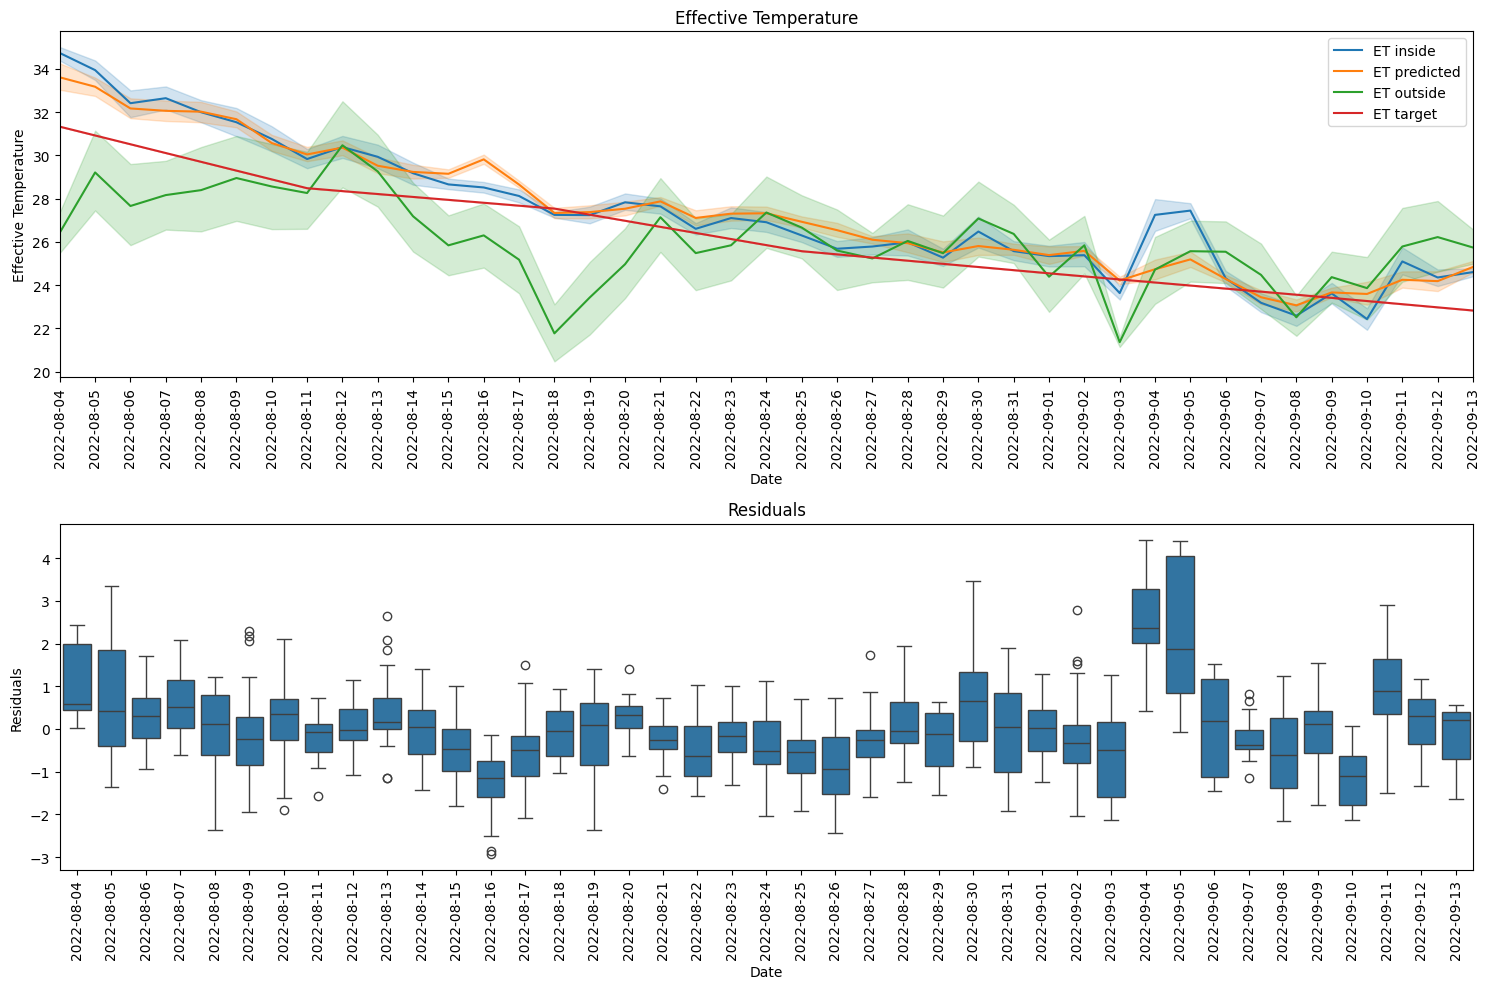

In [ ]:
# and plot
dates = [df['date'].min()+timedelta(days=day) for day in range(0,df['day_of_production'].max()+1,1)]

fig, axs = plt.subplots(2,1, figsize=(15,10))
plot1 = sns.lineplot(data=df,x='date', y='ET', label=farm_features['ET'], ax=axs[0],legend=True)
sns.lineplot(data=df,x='date', y='ET_pred', label='ET predicted', ax=axs[0],legend=True)
sns.lineplot(data=df,x='date', y='et', label=weather_features['et'], ax=axs[0],legend=True)
sns.lineplot(data=df,x='date', y='t_ET', label=targets_features['t_ET'], ax=axs[0],legend=True)
axs[0].set_title('Effective Temperature')
axs[0].margins(x=0)
# axs[0].set_xlim(df['date'].min(),df['date'].max())
axs[0].set_xticks(dates)
axs[0].tick_params("x", labelrotation=90)
axs[0].set_ylabel('Effective Temperature')
axs[0].set_xlabel('Date')
#and now the residuals
# Note that the boxplot converts the date to a categorical variable, so the axis is not a time axis
plot2 = sns.boxplot(data=df,x='date',y='Residuals',ax=axs[1])
axs[1].set_title('Residuals')
axs[1].tick_params("x", labelrotation=90)
axs[1].set_ylabel('Residuals')
axs[1].set_xlabel('Date')
plt.tight_layout();

# Discussion of results

We have attempted to understand the impact of outside weather conditions on the internal thermal sensation through a correlation analysis and a linear regression. After careful preparation of a data set and analysis of the correlations and the regression, we have established a simplified model where

>$$ET = a · t_{ET} + b · AS + c · tp4 + d · ah$$

where  
- $t_{ET}$ is the effective temperature target
- $AS$ is the air speed
- $tp4$ is the outside temperature 4 hours ago
- $ah$ is the outside absolute humidity

The regression results are reasonable with $R^2 = 0.87$. From the analysis of the residuals we can observe that there is still information contained in them and therefore the model can be improved - very likely by adding confounding features to which we might not have direct access.

The inspection of the simulated results compared to the real results show that the model is able to reproduce to some degree the modulation of the controller of the outside conditions. In some cases, the model underestimates the capacity of the controller to reduce the strong variation of the outside thermal environment (see 2022-08-16 above). The model is also not able to reproduce a strong variation from the target temperature on 4th and 5th of September 2022 where the controller seemingly was not able to properly react to a strong increase of outside temperature. The model is by no means perfect but at the same time it is a good first order approximation of the interplay between outside and inside conditions.

From the correlation analysis and the correlation coefficients we can conclude that clearly the controller is not able to keep the effective temperature independent of the outside conditions at all times. While the effect of outside absolute humidity is smaller, outside temperature has about half the impact of the internal temperature target. The barn has a reaction time of roughly 3-5 hours. This means that with the outside temperature 4 hours ago, the outside absolute humidity and the current inside conditions, it should be possible to predict reasonably well the inside temperature. 

The residuals have a standard deviation of about 1ºC, meaning that in 68% of cases the predicted temperature with this simplistic model is $\pm 1ºC$ off the real value (and in 95% of cases $\pm 2ºC$). This is in the same range of the temporal and spatial differences in effective temperature in the barn.


**Next steps**
- Given that the data are time series, the toolbox for time series analysis (in particular autocorrelation analysis, trend decomposition etc) should be undertaken to improve the quality of the fit and of the prediction